In [319]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from geopy import distance # geo_distance
from math import cos, radians 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'train.csv', 'test.csv', 'GCP-Coupons-Instructions.rtf']


In [320]:
train =  pd.read_csv('../input/train.csv', nrows=1000000)
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [321]:
train['pickup_datetime']= pd.to_datetime(train['pickup_datetime']) # convert to datetime
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [322]:
train.isnull().sum()

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64

In [323]:
train.dropna(inplace=True)

**Remove Unrealistic Data**

In [324]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000,999990.000000
mean,11.347953,-72.526699,39.929040,-72.527860,39.919954,1.684941
std,9.821790,12.057778,7.626087,11.324494,8.201418,1.323907
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [325]:
train.drop(train[train.fare_amount <= 0].index, inplace=True) # Drop -ve fare values
train.drop(train[(train.pickup_longitude > 180) | (train.dropoff_longitude > 180) | (train.pickup_longitude < -180) | (train.dropoff_longitude < -180)].index, inplace=True) # Drop unrealistic longtiudes
train.drop(train[(train.pickup_latitude > 90) | (train.dropoff_latitude > 90) | (train.pickup_latitude < -90) | (train.dropoff_latitude < -90)].index, inplace=True) # Drop unrealistic longtiudes
train.drop(train[train.passenger_count > 6].index, inplace=True) # Drop unrealistic passenger_count

Some pickup locations are exactly the same coords as the dropoff locations. These are most probably errors but since there are similar entries in the testing data, we can't drop them out.

We will drop all of them except for the ones having minimum fare which could be translated as the minimum fare you would pay even if you ride the taxi for 1 meter. 

In [326]:
minimum_fare = train[(train.pickup_longitude == train.dropoff_longitude) & 
                     (train.pickup_latitude == train.dropoff_latitude)].fare_amount.min()

train.drop(train[(train.pickup_longitude == train.dropoff_longitude) & 
                 (train.pickup_latitude == train.dropoff_latitude) & 
                 (train.fare_amount > minimum_fare)].index, inplace=True) # Drop expensive fares with 0 distances

In [327]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,971406.000000,971406.000000,971406.000000,971406.000000,971406.000000,971406.000000
mean,11.343753,-73.841244,40.655125,-73.839484,40.654431,1.685410
std,9.691035,3.500844,2.853403,3.509169,2.861720,1.308175
min,0.010000,-128.175950,-74.016587,-121.391248,-74.035197,0.000000
25%,6.000000,-73.992267,40.736490,-73.991565,40.735454,1.000000
50%,8.500000,-73.982088,40.753368,-73.980587,40.753832,1.000000
75%,12.500000,-73.968353,40.767547,-73.965347,40.768404,2.000000
max,495.000000,40.850357,69.400000,45.581619,81.510177,6.000000


I still see unrealistic longtiudes, which obviously are not in NYC. We should drop more unrealistic coordinates by defining the range for NYC.

As per Google:  -73.935242, 40.730610 is the center of NYC.

We will drop all values that differs by more than 2 degree in any value.

In [328]:
train.drop(train[ (train.pickup_longitude > -71.9) | (train.dropoff_longitude > -71.9) | (train.pickup_longitude < -75.9) | (train.dropoff_longitude < -75.9) ].index, inplace=True) # Drop unrealistic longtiudes
train.drop(train[ (train.pickup_latitude > 42.7) | (train.dropoff_latitude > 42.7) | (train.pickup_latitude < 38.7) | (train.dropoff_latitude < 38.7) ].index, inplace=True) # Drop unrealistic longtiudes
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,968874.000000,968874.000000,968874.000000,968874.000000,968874.000000,968874.000000
mean,11.336232,-73.975516,40.750856,-73.974604,40.751193,1.685148
std,9.670510,0.037883,0.030697,0.036822,0.033901,1.307750
min,0.010000,-75.703165,38.976528,-75.728118,38.955527,0.000000
25%,6.000000,-73.992283,40.736585,-73.991580,40.735588,1.000000
50%,8.500000,-73.982106,40.753423,-73.980623,40.753887,1.000000
75%,12.500000,-73.968457,40.767582,-73.965483,40.768423,2.000000
max,495.000000,-72.188730,42.208460,-72.151010,42.386605,6.000000


**Get Geodesic Distance:**

This returns the most accurate euclidean distance between coordinates as it takes into account that earth is not a perfect sphere.

In [329]:
# ALERT - 1M rows were computed in 5 mins on a powerful PC
# We will use this just as a reference later on.
def geodesic_distance (row):
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    return distance.distance(pickup, dropoff).km

%time train['geo_distance'] = train.apply(lambda row: geodesic_distance(row), axis=1)

CPU times: user 4min 19s, sys: 200 ms, total: 4min 19s
Wall time: 4min 19s


**Get the Manhattan Distance (Corrected) - Rounded:**

ojones3, pointed out to a possible optimization in calculating the distance, I will follow his idea as I believe it is more accurate indeed. (https://www.kaggle.com/ojones3/feature-engineering-corrected-manhattan-distance)
![](https://i.imgur.com/ZPlvFzO.png)

* 1 degree of latitude ~= 111 KM anywhere on Earth.
* 1 degree of longtiude varies greatly with the latitude so we will need to calculate it.

In [330]:
degree_latitude = 111
degree_longtiude = cos(radians(train.pickup_latitude.mean())) * degree_latitude
print(degree_longtiude)

84.08863134852236


In [331]:
train['abs_diff_longitude'] = (train.dropoff_longitude - train.pickup_longitude).abs()
train['abs_diff_latitude'] = (train.dropoff_latitude - train.pickup_latitude).abs()

train['abs_diff_longitude_km'] = train.abs_diff_longitude * degree_longtiude
train['abs_diff_latitude_km'] = train.abs_diff_latitude * degree_latitude

train['manhattan_distance'] = train.abs_diff_longitude_km + train.abs_diff_latitude_km

![](https://drive.google.com/uc?id=1rTmbmJNvgeZ0Af4s876V1xCKjF8EMpih)

In [332]:
### Angle difference between north, and manhattan roadways
meas_ang = radians(29)

## adding extra features
def add_extra_manh_features(df):
    df['euclidean'] = (df.abs_diff_latitude_km**2 + df.abs_diff_longitude_km**2)**0.5 ### as the crow flies  
    df['delta_manh_long'] = (df.euclidean*np.sin(np.arctan(df.abs_diff_longitude_km / df.abs_diff_latitude_km)-meas_ang)).abs()
    df['delta_manh_lat'] = (df.euclidean*np.cos(np.arctan(df.abs_diff_longitude_km / df.abs_diff_latitude_km)-meas_ang)).abs()
    df.delta_manh_long.fillna(0, inplace=True) # happens if pickup coords = dropoff coords
    df.delta_manh_lat.fillna(0, inplace=True)
    df['manhattan_distance_corrected'] = df.delta_manh_long + df.delta_manh_lat

add_extra_manh_features(train)

The downside for this calculation is that we can not assume it return correct results outside Manhattan. By looking into the map, we can get better results outside Manhattan by running the normal cityblock distance formula ignoring any tilting.

In [333]:
# Sanity Check, we will compare the 2 euclidean distances we calculated (one very accurate 'geo_distance' and one rounded by calculating the length of 1 degree of longtiude and latitude)
# and the 2 manhattan distances
train[['geo_distance', 'euclidean', 'manhattan_distance', 'manhattan_distance_corrected']].head()

,geo_distance,euclidean,manhattan_distance,manhattan_distance_corrected
0,1.029601,1.028931,1.230674,1.275722
1,8.443441,8.435249,10.940591,9.462948
2,1.389132,1.387117,1.903678,1.435438
3,2.795790,2.794359,3.142440,3.619282
4,1.998338,1.995827,2.710668,2.002239


I will use 3 distances for the final distance covered:
1. manhattan_distance_corrected: if the trip started and ended in Manhattan.
2. manhattan_distance: if the trip started and ended outside Manhattan.
3. mean of manhattan_distance_corrected and manhattan_distance: if the trip either started or ended only in Manhattan.
Those assumptions will not be accurate every time but they are 'educated guesses'.


In [334]:
# Ideally, we should break down the island into smaller pieces due to its orientation but this is only a rough estimation.
def manh_checker(x):
    if 40.7031 < x['dropoff_latitude'] < 40.83 and -74.017 < x['dropoff_longitude'] < -73.909 and \
       40.7031 < x['pickup_latitude'] < 40.83 and -74.017 < x['pickup_longitude'] < -73.909:
        return 1
    elif 40.7091 < x['dropoff_latitude'] < 40.83 and -74.017 < x['dropoff_longitude'] < -73.909 and \
        (not 40.7031 < x['pickup_latitude'] < 40.83 or not -74.017 < x['pickup_longitude'] < -73.909):
        return 2
    elif (not 40.7031 < x['dropoff_latitude'] < 40.83 or not -74.017 < x['dropoff_longitude'] < -73.909) and \
          40.7091 < x['pickup_latitude'] < 40.83 and -74.017 < x['pickup_longitude'] < -73.909:
        return 3
    else:
        return 0
    
train['manh_island'] = train.apply(manh_checker, axis=1) 

In [335]:
# Percentages:
print('Inside Manhattan = {:.2f}, Outside Manhattan = {:.2f}, Mixed = {:.2f}'.format(len(train[train.manh_island == 1])/len(train), len(train[train.manh_island == 0])/len(train), len(train[train.manh_island == 2])/len(train)))

Inside Manhattan = 0.88, Outside Manhattan = 0.03, Mixed = 0.04


In [336]:
def final_distance_calculator(x):
    if x.manh_island == 1:
        return x.manhattan_distance_corrected
    elif x.manh_island == 2 or x.manh_island == 3:
        return (x.manhattan_distance_corrected + x.manhattan_distance) / 2
    elif x.manh_island == 0:
        return x.manhattan_distance
train['final_distance'] = train.apply(final_distance_calculator, axis=1)

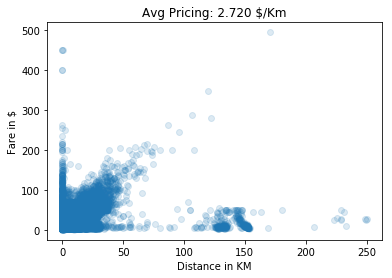

In [337]:
# Let's try to figure out the relation between the fare and the travelled distance
plt.scatter(train.final_distance, train.fare_amount, alpha=0.15)
plt.title('Avg Pricing: {:.3f} $/Km'.format(np.sum(train.fare_amount)/np.sum(train.final_distance)))
plt.xlabel('Distance in KM')
plt.ylabel('Fare in $')
plt.show()

What is interesting is the cheap cluster with distances around 150km.
Some of the entries seems like an error too. Like the $450 fare with very short distance.

In [338]:
train[(train.fare_amount > 300) & (train.final_distance < 20)][['fare_amount', 'final_distance', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

,fare_amount,final_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
233874,450.0,0.788696,-73.931985,40.793829,-73.929148,40.799672
287638,450.0,0.002565,-73.909019,40.777611,-73.908997,40.777607
329010,450.0,0.001929,-73.955373,40.810310,-73.955372,40.810323
361793,400.0,0.001840,-73.852663,40.897932,-73.852673,40.897923
451974,400.0,0.011711,-73.943676,40.708061,-73.943665,40.708141


Extremely short distances for such price probably these entries are incorrect.

In [339]:
# What is this cheap cluster @ 120 to 150km?
train[(train.fare_amount < 100) & (train.final_distance > 100)][['fare_amount', 'final_distance']].head()

,fare_amount,final_distance
1684,2.50,133.111376
3075,6.90,130.475580
4487,4.90,127.692232
5663,49.15,134.599631
7401,4.50,131.006694


More unrealistic erros here, the first row shows a 133 Km trip, paying only $2.5
We will drop those values later, but we need to really define our limits, how much is way too expensive/cheap?
Let's explore the fare_rate and decide.

In [340]:
train['fare_rate'] = train.fare_amount/train.final_distance
print(train.fare_rate.describe())
print('Avg per KM: {}'.format(np.sum(train.fare_amount)/np.sum(train.final_distance)))
print(np.percentile(train.fare_rate, 99.5)) # Rate which 99.5% of trips fall behind
print(np.percentile(train.fare_rate, 0.3)) # Rate which 99.7% of trips fall after

count    9.688740e+05
mean     7.300925e+01
std      4.390999e+03
min      1.029490e-03
25%      2.473399e+00
50%      3.124446e+00
75%      4.092322e+00
max      1.063063e+06
Name: fare_rate, dtype: float64
Avg per KM: 2.7199230126698586
78.72476898615136
0.9968522990054266


In [341]:
train.drop(train[(train.fare_rate > np.percentile(train.fare_rate, 99.7)) | \
                  (train.fare_rate < np.percentile(train.fare_rate, 0.3))].index, 
           inplace=True) # Drop extremely expensive/cheap trips

**Pick up time:**


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


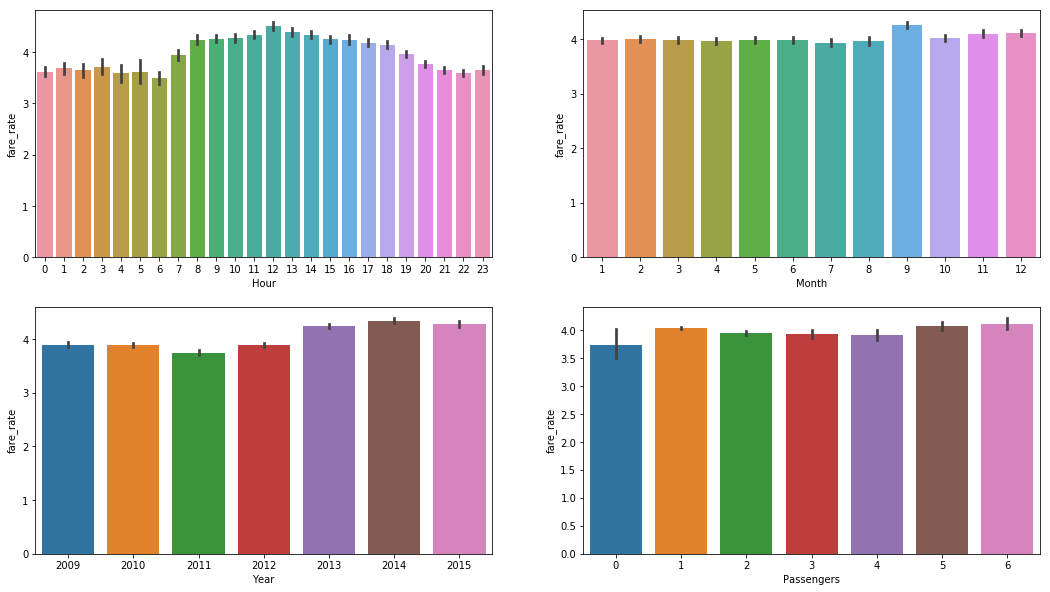

In [342]:
plt.figure(figsize=(18, 10))
plt.subplot(221)
sns.barplot(train.pickup_datetime.dt.hour, train.fare_rate)
plt.xlabel('Hour')
plt.subplot(222)
sns.barplot(train.pickup_datetime.dt.month, train.fare_rate)
plt.xlabel('Month')
plt.subplot(223)
sns.barplot(train.pickup_datetime.dt.year, train.fare_rate)
plt.xlabel('Year')
plt.subplot(224)
sns.barplot(train.passenger_count, train.fare_rate)
plt.xlabel('Passengers')
plt.show()

Pickup hour does matter, later years are more expensive as well. Last 4 months in the year are a little more expensive too. I will create new features with one hot encoding for what I can extract from this graphs.

1. morning_afternoon: 08:00 to 19:00 >> Expensive
2. last_4_months
3. exp_year (>= 2013)

In [343]:
train['morning_afternoon'] = train.pickup_datetime.dt.hour.apply(lambda x: 0 if 8 <= x <= 19 else 1)
train['last_4_months'] = train.pickup_datetime.dt.month.apply(lambda x: 0 if x >= 9 else 1)
train['exp_year'] = train.pickup_datetime.dt.year.apply(lambda x: 0 if x >= 2013 else 1)

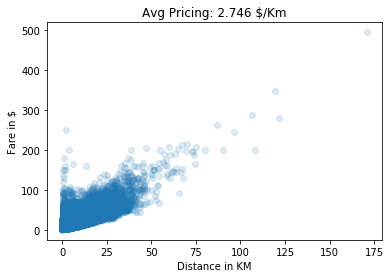

In [344]:
# Let's see the data one more time after all the cleaning
plt.scatter(train.final_distance, train.fare_amount, alpha=0.15)
plt.title('Avg Pricing: {:.3f} $/Km'.format(np.sum(train.fare_amount)/np.sum(train.final_distance)))
plt.xlabel('Distance in KM')
plt.ylabel('Fare in $')
plt.show()

Train score:  0.8418156639151317
Test score:  0.845716602842453
Weights:  [ 1.86645441 -1.10494872 -0.53508917 -2.03876728]


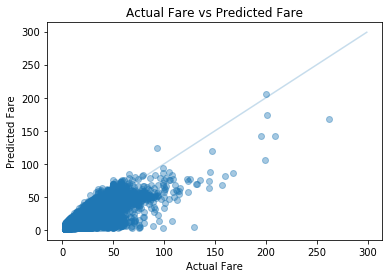

In [345]:
features = ['final_distance', 'morning_afternoon', 'last_4_months', 'exp_year']
x_train, x_test, y_train, y_test = train_test_split(train[features], train['fare_amount'], train_size = 0.8, test_size = 0.2, random_state=555)
lm = LinearRegression()
model = lm.fit(x_train, y_train)
y_predict= lm.predict(x_test)

print("Train score: ", lm.score(x_train, y_train))
print("Test score: ", lm.score(x_test, y_test))
print("Weights: ", lm.coef_)

plt.scatter(y_test, y_predict, alpha=0.4)
plt.plot(range(300), range(300), alpha=0.25)

plt.xlabel("Actual Fare")
plt.ylabel("Predicted Fare")
plt.title("Actual Fare vs Predicted Fare")
plt.show()


In [346]:
test =  pd.read_csv('../input/test.csv')
test['pickup_datetime']= pd.to_datetime(test['pickup_datetime']) # convert to datetime
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [347]:
test['abs_diff_longitude'] = (test.dropoff_longitude - test.pickup_longitude).abs()
test['abs_diff_latitude'] = (test.dropoff_latitude - test.pickup_latitude).abs()
test['abs_diff_longitude_km'] = test.abs_diff_longitude * degree_longtiude
test['abs_diff_latitude_km'] = test.abs_diff_latitude * degree_latitude
test['manhattan_distance'] = test.abs_diff_longitude_km + test.abs_diff_latitude_km
add_extra_manh_features(test)
test['manh_island'] = test.apply(manh_checker, axis=1)
test['final_distance'] = test.apply(final_distance_calculator, axis=1)
test['morning_afternoon'] = test.pickup_datetime.dt.hour.apply(lambda x: 0 if 8 <= x <= 19 else 1)
test['last_4_months'] = test.pickup_datetime.dt.month.apply(lambda x: 0 if x >= 9 else 1)
test['exp_year'] = test.pickup_datetime.dt.year.apply(lambda x: 0 if x >= 2013 else 1)

In [350]:
lm = LinearRegression()
model = lm.fit(train[features], train['fare_amount'])
prediction = lm.predict(test[features])

In [ ]:
submission = pd.DataFrame({"key": test.key, "fare_amount": prediction})
submission.to_csv('submission.csv', index=False)